In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')

import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression


from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier



from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_colwidth', -1)

import warnings
warnings.simplefilter('ignore')

In [303]:
train = pd.read_csv("train_Df64byy.csv")
test = pd.read_csv("test_YCcRUnU.csv")
ss = pd.read_csv("sample_submission_QrCyCoT.csv")

# 1. DataSet Contents

In [304]:
train.head(5)
test.head(3)

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0


,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium
0,50883,C1,156,Owned,Individual,30,30,No,NaN,6.0,3.0,5,11934.0
1,50884,C4,7,Owned,Joint,69,68,Yes,X1,3.0,3.0,18,32204.8
2,50885,C1,564,Rented,Individual,28,28,No,X3,2.0,4.0,17,9240.0


In [305]:
ID_COL, TARGET_COL = 'ID', 'Response'

In [306]:
print(f'\nTrain contains {train.shape[0]} samples and {train.shape[1]} variables')
print(f'\nTest contains {test.shape[0]} samples and {test.shape[1]} variables')

features = [c for c in train.columns if c not in [ID_COL, TARGET_COL]]
print(f'\nThe dataset contains {len(features)} features')


Train contains 50882 samples and 14 variables

Test contains 21805 samples and 13 variables

The dataset contains 12 features


In [307]:
train[TARGET_COL].value_counts(normalize=True)

0    0.760053
1    0.239947
Name: Response, dtype: float64

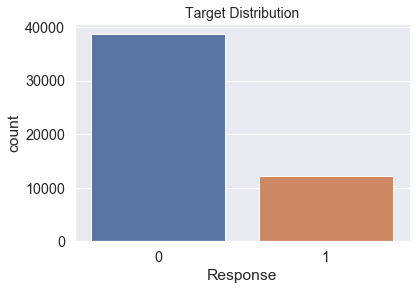

In [308]:
_ = sns.countplot(train[TARGET_COL])
_ = plt.title("Target Distribution", fontsize=14)

In [309]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Data columns (total 14 columns):
ID                         50882 non-null int64
City_Code                  50882 non-null object
Region_Code                50882 non-null int64
Accomodation_Type          50882 non-null object
Reco_Insurance_Type        50882 non-null object
Upper_Age                  50882 non-null int64
Lower_Age                  50882 non-null int64
Is_Spouse                  50882 non-null object
Health Indicator           39191 non-null object
Holding_Policy_Duration    30631 non-null object
Holding_Policy_Type        30631 non-null float64
Reco_Policy_Cat            50882 non-null int64
Reco_Policy_Premium        50882 non-null float64
Response                   50882 non-null int64
dtypes: float64(2), int64(6), object(6)
memory usage: 5.4+ MB


In [310]:
train.nunique()

ID                         50882
City_Code                  36   
Region_Code                5316 
Accomodation_Type          2    
Reco_Insurance_Type        2    
Upper_Age                  58   
Lower_Age                  60   
Is_Spouse                  2    
Health Indicator           9    
Holding_Policy_Duration    15   
Holding_Policy_Type        4    
Reco_Policy_Cat            22   
Reco_Policy_Premium        6977 
Response                   2    
dtype: int64

In [311]:
null_values_per_variable = 100*(train.isnull().sum()/len(train)).round(3)
null_values_per_variable.sort_values(ascending=False)

Holding_Policy_Type        39.8
Holding_Policy_Duration    39.8
Health Indicator           23.0
Response                   0.0 
Reco_Policy_Premium        0.0 
Reco_Policy_Cat            0.0 
Is_Spouse                  0.0 
Lower_Age                  0.0 
Upper_Age                  0.0 
Reco_Insurance_Type        0.0 
Accomodation_Type          0.0 
Region_Code                0.0 
City_Code                  0.0 
ID                         0.0 
dtype: float64

In [312]:
train.columns

Index(['ID', 'City_Code', 'Region_Code', 'Accomodation_Type',
       'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Is_Spouse',
       'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type',
       'Reco_Policy_Cat', 'Reco_Policy_Premium', 'Response'],
      dtype='object')

In [313]:
categorical = train.select_dtypes(include=['object'])


In [314]:
cat_cols = [c for c in features if c in categorical]
cat_cols

['City_Code',
 'Accomodation_Type',
 'Reco_Insurance_Type',
 'Is_Spouse',
 'Health Indicator',
 'Holding_Policy_Duration']

In [315]:
num_cols = [n for n in features if n not in cat_cols]
num_cols

['Region_Code',
 'Upper_Age',
 'Lower_Age',
 'Holding_Policy_Type',
 'Reco_Policy_Cat',
 'Reco_Policy_Premium']

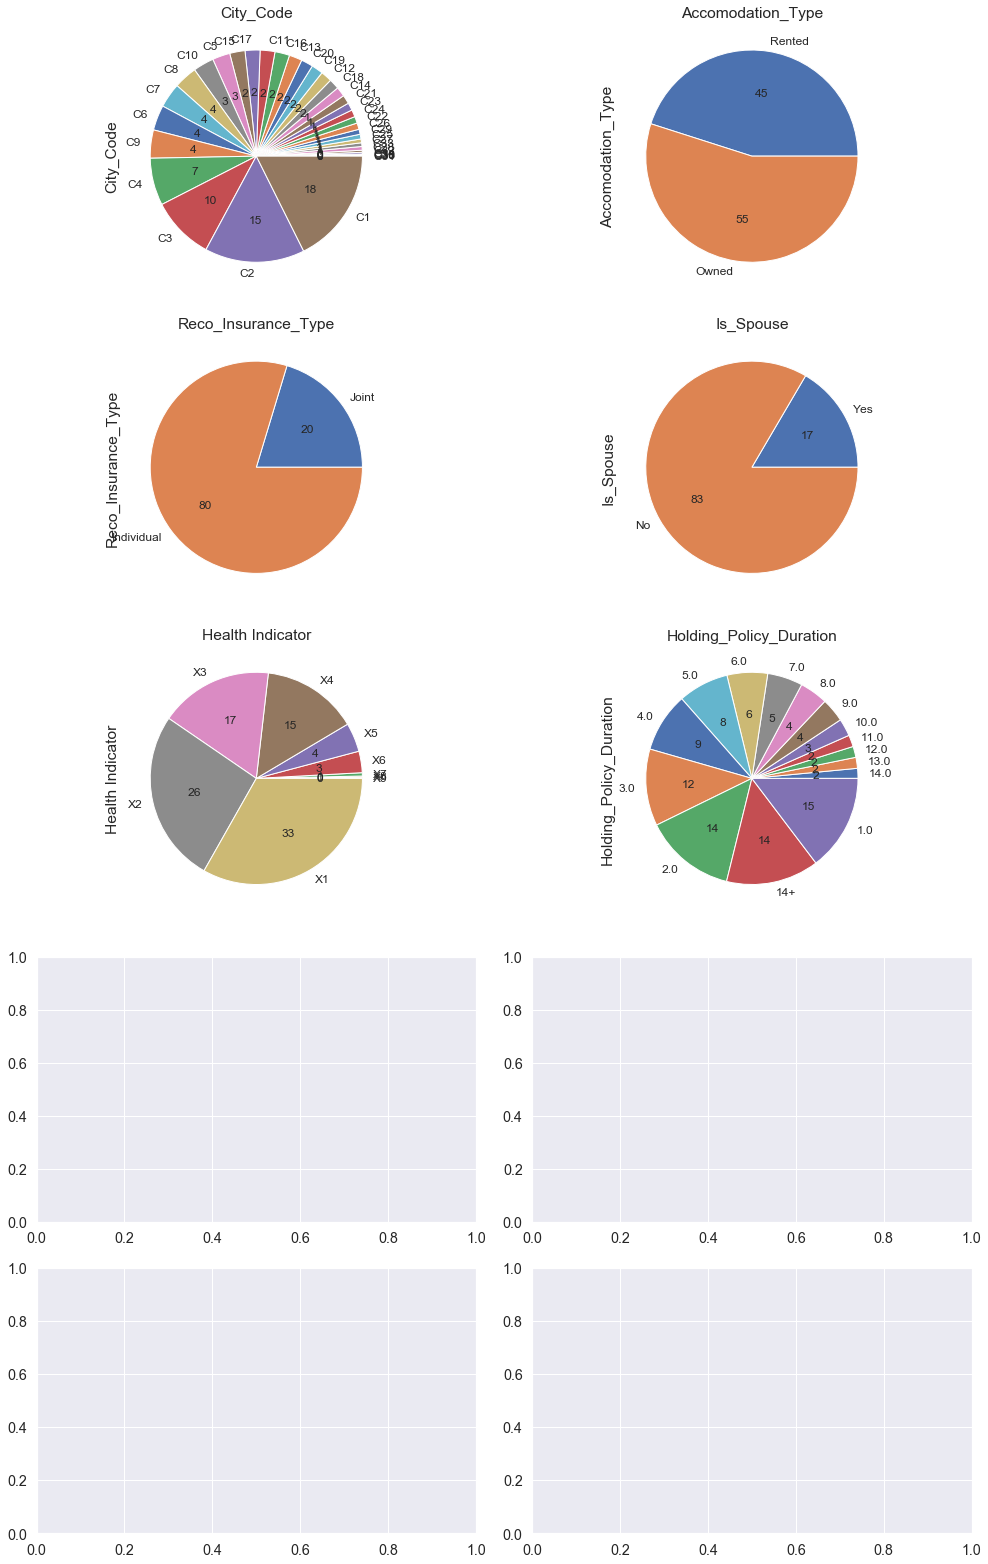

In [316]:
fig, axes = plt.subplots(5,2, figsize=(14,22))
axes = [ax for axes_row in axes for ax in axes_row]

for i,c in enumerate(train[cat_cols]):
  _ = train[c].value_counts()[::-1].plot(kind='pie', ax=axes[i], title=c, autopct="%.0f", fontsize=12)
  _ = axes[i].set_label('')
_ = plt.tight_layout()

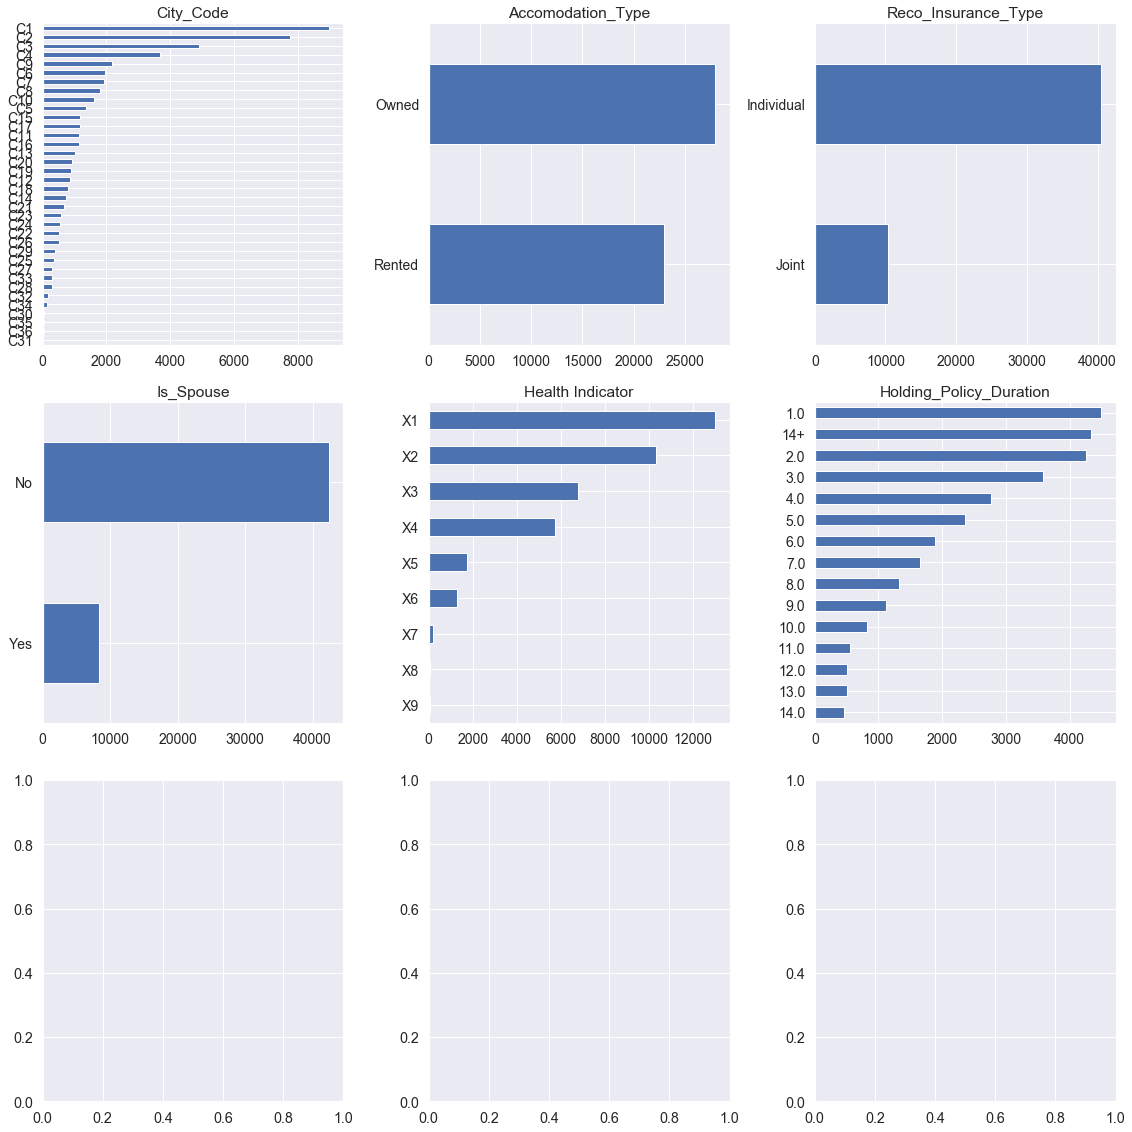

In [317]:
fig, axes = plt.subplots(3, 3, figsize=(16, 16))
axes = [ax for axes_row in axes for ax in axes_row]

for i, c in enumerate(train[cat_cols]):
    _ = train[c].value_counts()[::-1].plot(kind = 'barh', ax=axes[i], title=c, fontsize=14)
    
_ = plt.tight_layout()

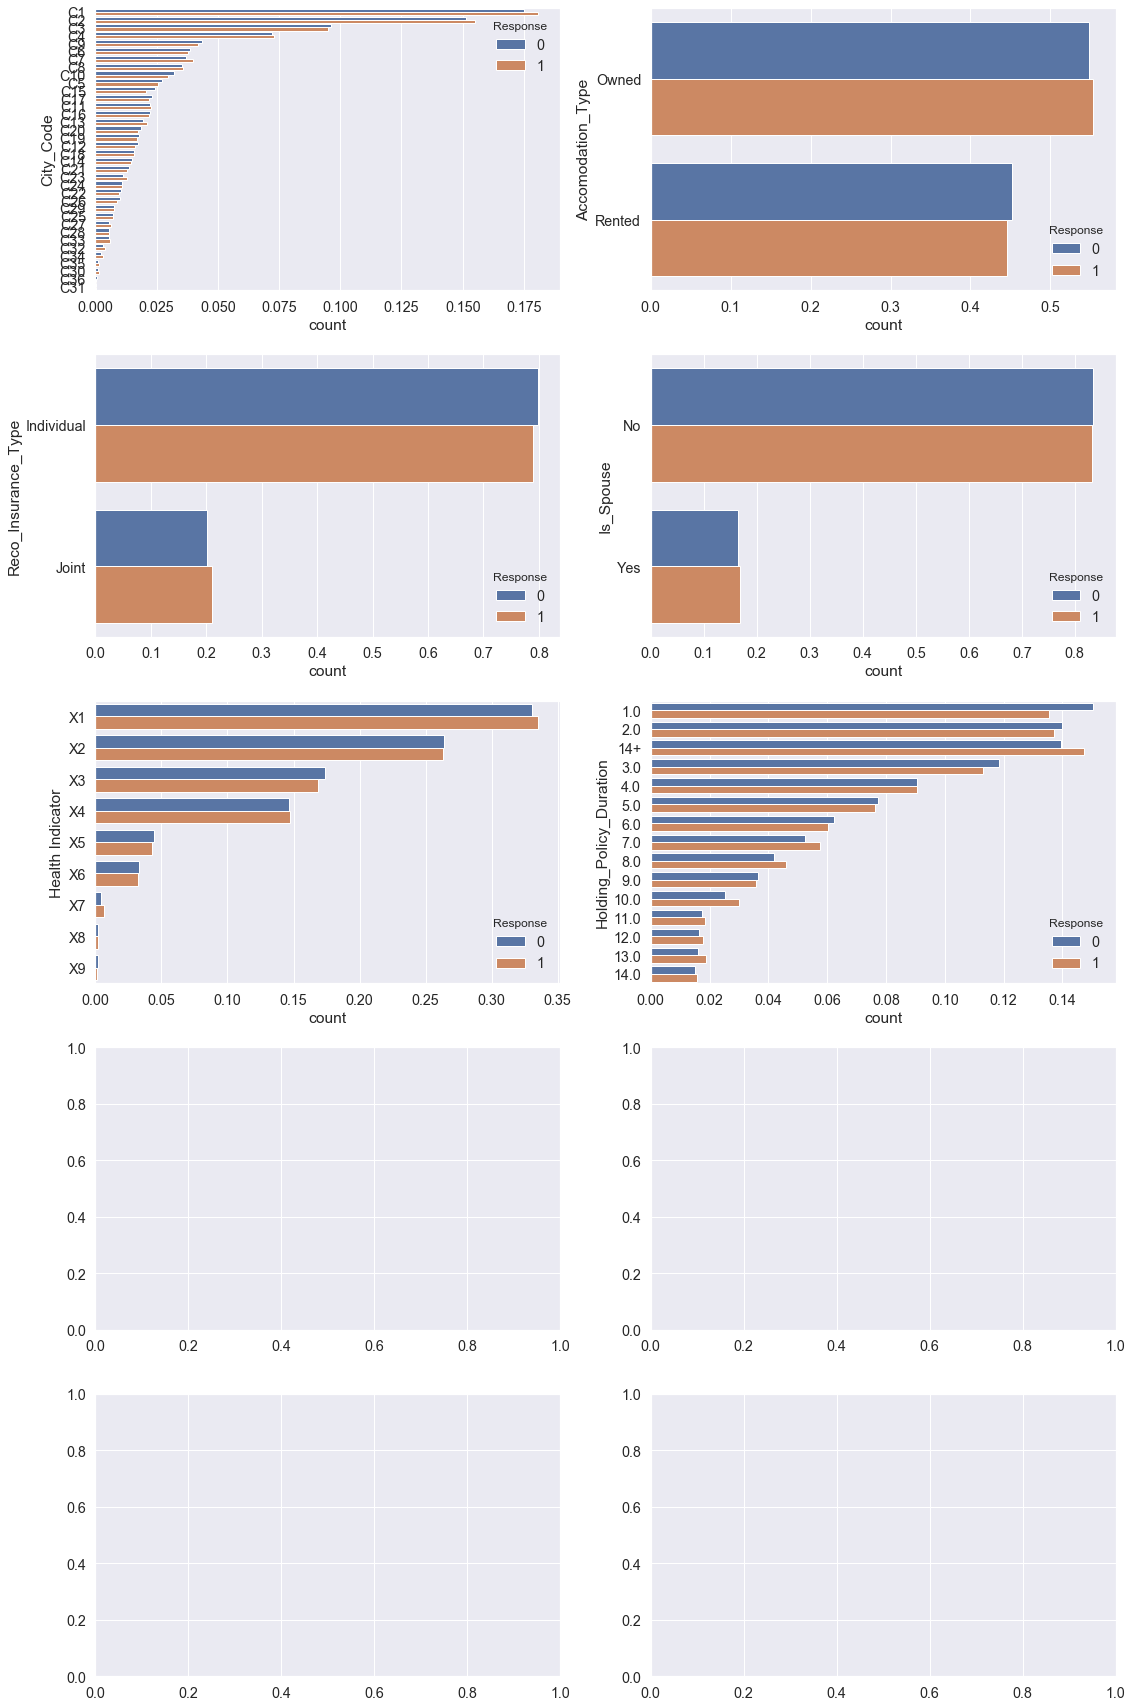

In [318]:
fig, axes = plt.subplots(5, 2, figsize=(16, 24))
axes = [ax for axes_row in axes for ax in axes_row]

for i, c in enumerate(train[cat_cols]):
    fltr = train[TARGET_COL] == 0
    vc_a = train[fltr][c].value_counts(normalize=True).reset_index().rename({'index' : c, c: 'count'}, axis=1)

    vc_b = train[~fltr][c].value_counts(normalize=True).reset_index().rename({'index' : c, c: 'count'}, axis=1)

    vc_a[TARGET_COL] = 0
    vc_b[TARGET_COL] = 1

    df = pd.concat([vc_a, vc_b]).reset_index(drop = True)

    _ = sns.barplot(y = c, x = 'count', data =df , hue=TARGET_COL, ax=axes[i])
    
_ = plt.tight_layout()

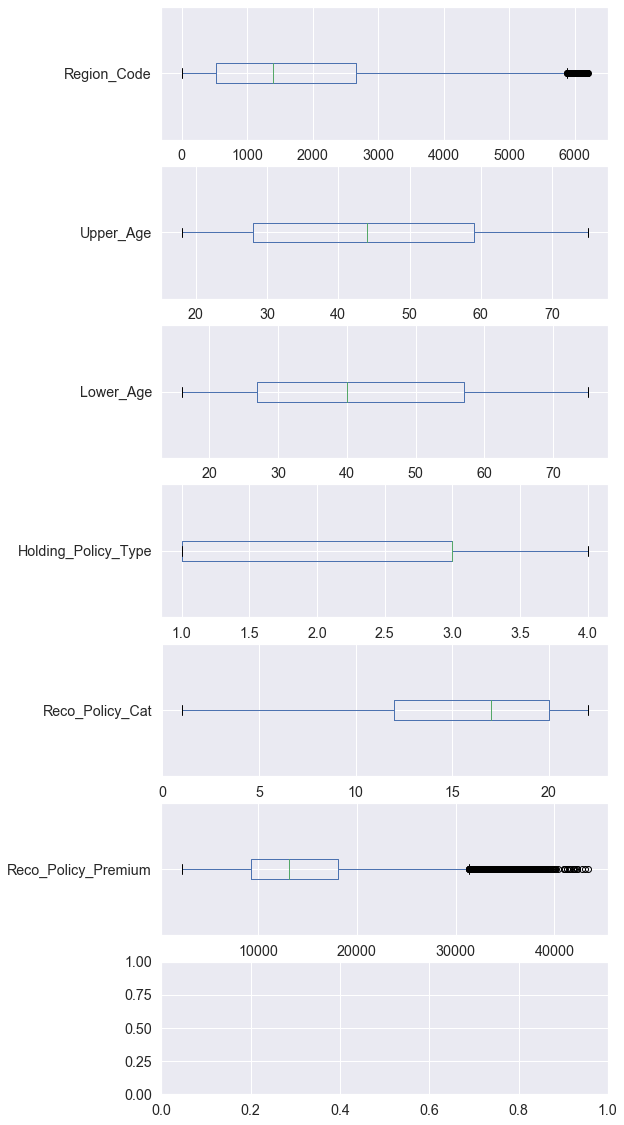

In [319]:
fig, axes = plt.subplots(7, 1, figsize=(8, 20))
for i, c in enumerate(num_cols):
  _ = train[[c]].boxplot(ax=axes[i], vert=False)

In [320]:
train

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50877,50878,C4,845,Rented,Individual,22,22,No,X3,NaN,NaN,18,7704.0,0
50878,50879,C5,4188,Rented,Individual,27,27,No,X3,7.0,3.0,4,5408.0,0
50879,50880,C1,442,Rented,Individual,63,63,No,X2,14+,1.0,12,11374.0,0
50880,50881,C1,4,Owned,Joint,71,49,No,X2,2.0,2.0,16,28179.2,1


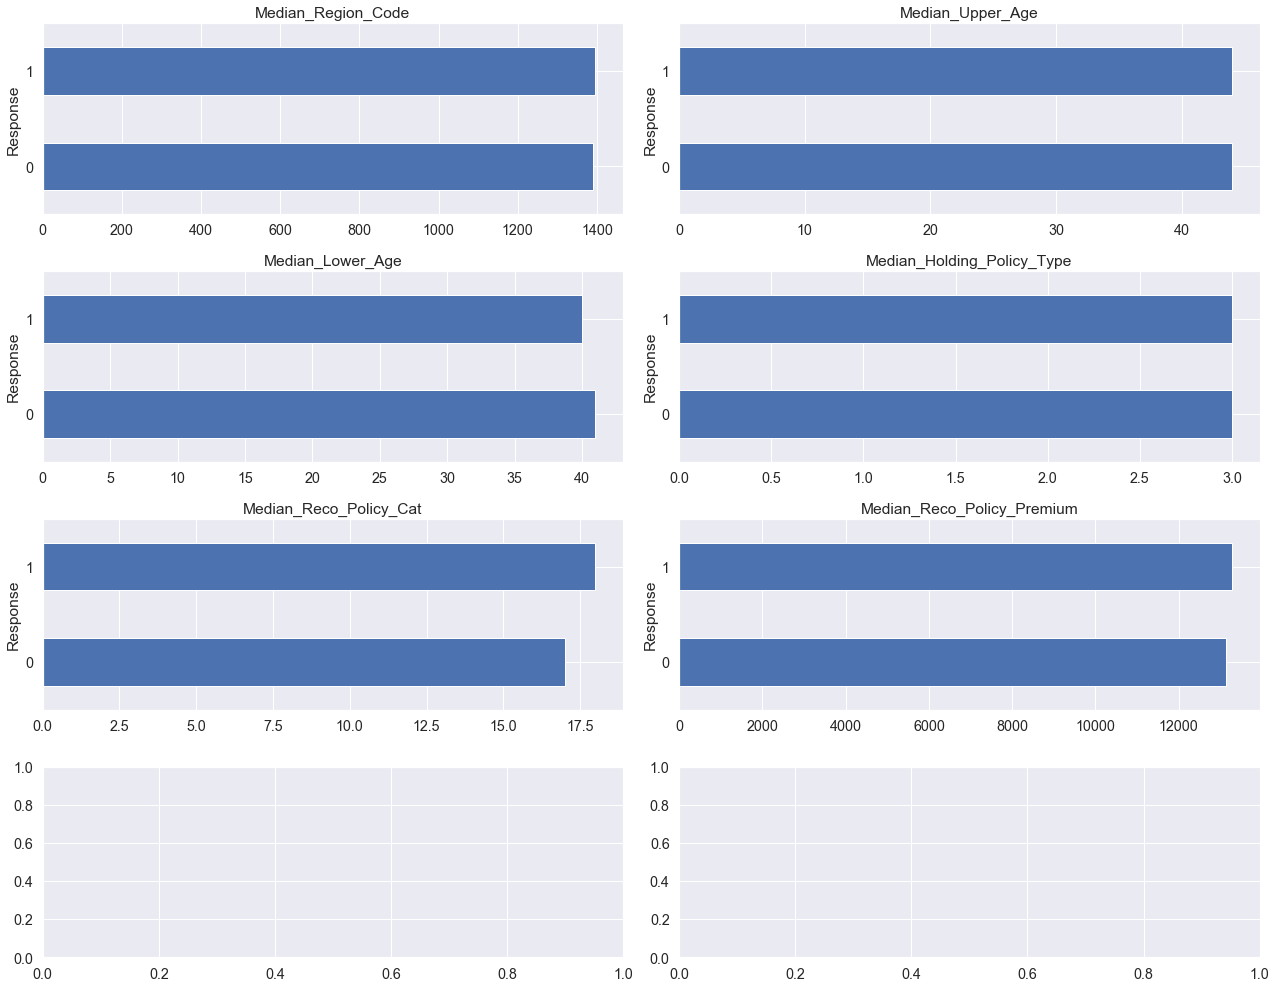

In [321]:
sns.set(font_scale=1.3)
fig, axes = plt.subplots(4, 2, figsize=(18, 14))
axes = [ax for axes_row in axes for ax in axes_row]
for i, c in enumerate(num_cols):
  plot = train.groupby(TARGET_COL)[c].median().plot(kind = 'barh', title=f'Median_{c}', ax=axes[i])
plt.tight_layout()

In [322]:
df = pd.concat([train, test], axis=0).reset_index(drop = True)
df.shape

(72687, 14)

In [324]:
df.columns

Index(['Accomodation_Type', 'City_Code', 'Health Indicator',
       'Holding_Policy_Duration', 'Holding_Policy_Type', 'ID', 'Is_Spouse',
       'Lower_Age', 'Reco_Insurance_Type', 'Reco_Policy_Cat',
       'Reco_Policy_Premium', 'Region_Code', 'Response', 'Upper_Age'],
      dtype='object')

In [325]:
df['New_Class_City_Region'] =  df.groupby(['City_Code','Region_Code']).ngroup()

df['Upr_Low_Age_Average']   =  (df['Upper_Age']+df['Lower_Age'])/2

df['Holding_Policy_Duration']= df.sort_values(by=['Upr_Low_Age_Average','Holding_Policy_Duration'])['Holding_Policy_Duration'].ffill()

df['Holding_Policy_Type']= df.sort_values(by=['Holding_Policy_Duration','Holding_Policy_Type'])['Holding_Policy_Type'].ffill()

df['Reco_Policy_Cat']= df.sort_values(by=['Holding_Policy_Type','Reco_Policy_Cat'])['Reco_Policy_Cat'].ffill()

df['New_Class_insurance_duration'] =  df.groupby(['Holding_Policy_Duration','Reco_Insurance_Type']).ngroup()

df['New_Class_Spouse_Upr_Low_Age_Average'] =  df.groupby(['Is_Spouse','Upr_Low_Age_Average']).ngroup()

df['New_Class_Holding_Policy_Duration_Holding_Policy_Type_Average'] =  df.groupby(['Holding_Policy_Duration','Holding_Policy_Type']).ngroup()

df['New_Class_Reco_Policy_Premium_Holding_Policy_Type'] =  df.groupby(['Reco_Policy_Premium','Holding_Policy_Type']).ngroup()

df = df.drop(['Lower_Age', 'Upper_Age'], axis = 1)

In [326]:
df = df.drop(['ID'], axis = 1)

In [327]:
df = pd.get_dummies(df, columns= cat_cols)

In [328]:
df.head()

,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Region_Code,Response,New_Class_City_Region,Upr_Low_Age_Average,New_Class_insurance_duration,New_Class_Spouse_Upr_Low_Age_Average,New_Class_Holding_Policy_Duration_Holding_Policy_Type_Average,...,Holding_Policy_Duration_14+,Holding_Policy_Duration_14.0,Holding_Policy_Duration_2.0,Holding_Policy_Duration_3.0,Holding_Policy_Duration_4.0,Holding_Policy_Duration_5.0,Holding_Policy_Duration_6.0,Holding_Policy_Duration_7.0,Holding_Policy_Duration_8.0,Holding_Policy_Duration_9.0
0,3.0,22,11628.0,3213,0.0,3898,36.0,10,37,22,...,1,0,0,0,0,0,0,0,0,0
1,4.0,22,30510.0,1117,0.0,4540,48.5,29,62,59,...,0,0,0,0,0,0,0,0,0,1
2,1.0,19,7450.0,3732,1.0,4603,32.0,0,29,0,...,0,0,0,0,0,0,0,0,0,0
3,3.0,19,17780.0,4378,0.0,3332,50.0,11,65,22,...,1,0,0,0,0,0,0,0,0,0
4,1.0,16,10404.0,2190,0.0,5141,44.0,16,53,32,...,0,0,0,1,0,0,0,0,0,0


In [329]:
df.corr()

,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Region_Code,Response,New_Class_City_Region,Upr_Low_Age_Average,New_Class_insurance_duration,New_Class_Spouse_Upr_Low_Age_Average,New_Class_Holding_Policy_Duration_Holding_Policy_Type_Average,...,Holding_Policy_Duration_14+,Holding_Policy_Duration_14.0,Holding_Policy_Duration_2.0,Holding_Policy_Duration_3.0,Holding_Policy_Duration_4.0,Holding_Policy_Duration_5.0,Holding_Policy_Duration_6.0,Holding_Policy_Duration_7.0,Holding_Policy_Duration_8.0,Holding_Policy_Duration_9.0
Holding_Policy_Type,1.000000,0.037342,-0.089334,0.005400,0.003896,0.018670,-0.121779,0.428788,-0.071514,0.475140,...,-0.108549,-0.045205,-0.144916,-0.174307,0.024652,-0.122126,0.068094,0.012460,0.008798,0.447873
Reco_Policy_Cat,0.037342,1.000000,0.060442,-0.062533,0.114321,-0.074120,0.022671,0.015208,0.029140,0.016340,...,0.024926,0.001252,-0.021609,-0.005276,-0.001680,0.004842,0.009233,0.007686,-0.000321,0.004436
Reco_Policy_Premium,-0.089334,0.060442,1.000000,-0.013772,0.007943,-0.152548,0.716706,0.031857,0.797461,0.001645,...,0.189033,0.057031,-0.067827,0.003842,-0.136799,0.032652,-0.143034,-0.044546,-0.026490,0.117206
Region_Code,0.005400,-0.062533,-0.013772,1.000000,0.001121,0.128646,-0.005571,0.010660,-0.004944,0.011059,...,0.012358,-0.001041,-0.006201,-0.003638,0.005208,-0.000150,0.009593,0.003513,0.005077,-0.001913
Response,0.003896,0.114321,0.007943,0.001121,1.000000,-0.001226,0.000343,0.009776,0.003032,0.009398,...,0.007719,0.001538,-0.002333,-0.005116,-0.006494,-0.000821,-0.006608,0.006993,0.005082,0.007563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Holding_Policy_Duration_5.0,-0.122126,0.004842,0.032652,-0.000150,-0.000821,-0.009008,0.036172,0.049284,0.031589,0.040130,...,-0.067324,-0.021326,-0.072890,-0.061002,-0.072800,1.000000,-0.065751,-0.051586,-0.046172,-0.132430
Holding_Policy_Duration_6.0,0.068094,0.009233,-0.143034,0.009593,-0.006608,0.006362,-0.154479,0.128916,-0.130494,0.132440,...,-0.091506,-0.028986,-0.099071,-0.082913,-0.098948,-0.065751,1.000000,-0.070115,-0.062756,-0.179997
Holding_Policy_Duration_7.0,0.012460,0.007686,-0.044546,0.003513,0.006993,-0.007973,-0.057987,0.154590,-0.040964,0.151725,...,-0.071792,-0.022741,-0.077727,-0.065051,-0.077631,-0.051586,-0.070115,1.000000,-0.049236,-0.141219
Holding_Policy_Duration_8.0,0.008798,-0.000321,-0.026490,0.005077,0.005082,-0.005850,-0.038413,0.185271,-0.017673,0.180630,...,-0.064257,-0.020355,-0.069569,-0.058223,-0.069483,-0.046172,-0.062756,-0.049236,1.000000,-0.126397


In [330]:
df['Holding_Policy_Type'] = df['Holding_Policy_Type'].fillna(0)

In [331]:
df= df

In [332]:
# Splitting
train_proc, test_proc = df[:train.shape[0]], df[train.shape[0]:].reset_index(drop = True)
features = [c for c in train_proc.columns if c not in [ID_COL, TARGET_COL]]

In [333]:
features

['Holding_Policy_Type',
 'Reco_Policy_Cat',
 'Reco_Policy_Premium',
 'Region_Code',
 'New_Class_City_Region',
 'Upr_Low_Age_Average',
 'New_Class_insurance_duration',
 'New_Class_Spouse_Upr_Low_Age_Average',
 'New_Class_Holding_Policy_Duration_Holding_Policy_Type_Average',
 'New_Class_Reco_Policy_Premium_Holding_Policy_Type',
 'City_Code_C1',
 'City_Code_C10',
 'City_Code_C11',
 'City_Code_C12',
 'City_Code_C13',
 'City_Code_C14',
 'City_Code_C15',
 'City_Code_C16',
 'City_Code_C17',
 'City_Code_C18',
 'City_Code_C19',
 'City_Code_C2',
 'City_Code_C20',
 'City_Code_C21',
 'City_Code_C22',
 'City_Code_C23',
 'City_Code_C24',
 'City_Code_C25',
 'City_Code_C26',
 'City_Code_C27',
 'City_Code_C28',
 'City_Code_C29',
 'City_Code_C3',
 'City_Code_C30',
 'City_Code_C31',
 'City_Code_C32',
 'City_Code_C33',
 'City_Code_C34',
 'City_Code_C35',
 'City_Code_C36',
 'City_Code_C4',
 'City_Code_C5',
 'City_Code_C6',
 'City_Code_C7',
 'City_Code_C8',
 'City_Code_C9',
 'Accomodation_Type_Owned',
 'Acc

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
train_proc[features], train_proc[TARGET_COL] = smote.fit_resample(train_proc[features], train_proc[TARGET_COL])

In [174]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [175]:
trn, val = train_test_split(train_proc, test_size=0.2, random_state = 1, stratify = train_proc[TARGET_COL])

###### Input to our model will be the features
X_trn, X_val = trn[features], val[features]

###### Output of our model will be the TARGET_COL
y_trn, y_val = trn[TARGET_COL], val[TARGET_COL]

##### Features for the test data that we will be predicting
X_test = test_proc[features]

In [176]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
_ = scaler.fit(X_trn)

X_trn = scaler.transform(X_trn)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [177]:
clf = LogisticRegression(random_state = 1)
_ = clf.fit(X_trn, y_trn)

preds_val = clf.predict(X_val)

roc_auc_score(y_val, preds_val)

0.5

In [178]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier()
_   = clf.fit(X_trn, y_trn)

preds_val = clf.predict(X_val)

roc_auc_score(y_val, preds_val)

0.5082135405664818

In [179]:
from sklearn.ensemble import BaggingClassifier
clf =BaggingClassifier() 
_  = clf.fit(X_trn, y_trn)
preds_val = clf.predict(X_val)

roc_auc_score(y_val, preds_val)

0.536518754165813

In [180]:
from sklearn.naive_bayes import GaussianNB 
clf = GaussianNB() 
_ = clf.fit(X_trn, y_trn)

preds_val = clf.predict(X_val)
roc_auc_score(y_val, preds_val)

0.5066821890351302

In [181]:
preds_test = clf.predict(X_test)


In [182]:
'''from sklearn import svm
clf = svm.SVC(kernel='poly')
_ = clf.fit(X_trn, y_trn)
preds_val = clf.predict(X_val)

roc_auc_score(y_val, preds_val)'''

"from sklearn import svm\nclf = svm.SVC(kernel='poly')\n_ = clf.fit(X_trn, y_trn)\npreds_val = clf.predict(X_val)\n\nroc_auc_score(y_val, preds_val)"

In [183]:
X_trn[:5]



array([[-1.86494035,  0.48004895, -0.49349955,  0.33344832,  0.08009689,
         0.35713076,  1.4906031 ,  0.42709726, -0.01777088, -0.07625097,
        -0.46235298, -0.18199403, -0.15324637, -0.13170129, -0.1403206 ,
        -0.12117104, -0.15223577, -0.15257331, -0.15316238, -0.12668908,
        -0.13199059, -0.42179256, -0.138397  , -0.11681797, -0.1028408 ,
        -0.1093528 , -0.10513398, -0.08441395, -0.09962092, -0.07685176,
        -0.07422009, -0.08845288, -0.3258439 , -0.03399977, -0.01567579,
        -0.05638457, -0.07538249, -0.05085476, -0.03289556, -0.02891326,
        -0.27768382, -0.16665615, -0.20128676, -0.19728892,  5.1827651 ,
        -0.21112801, -1.10402026,  1.10402026,  0.50697683, -0.50697683,
         0.44601991, -0.44601991, -0.58604068,  1.9838685 , -0.38958746,
        -0.35711496, -0.18768006, -0.16128439, -0.06242365, -0.03999262,
        -0.03576476, -0.31314171, -0.12778568, -0.10525335, -0.10198351,
        -0.10024783, -0.30397329, -0.09525285, -0.3

In [184]:
clf = DecisionTreeClassifier(random_state = 1)
_ = clf.fit(X_trn, y_trn)

preds_val = clf.predict(X_val)

roc_auc_score(y_val, preds_val)

0.5540081275375394

In [185]:
clf = ExtraTreesClassifier(random_state = 1)
_ = clf.fit(X_trn, y_trn)

preds_val = clf.predict(X_val)

roc_auc_score(y_val, preds_val)

0.5069891952244893

In [186]:
clf = GradientBoostingClassifier(random_state = 1)
_ = clf.fit(X_trn, y_trn)

preds_val = clf.predict(X_val)

roc_auc_score(y_val, preds_val)

0.5009052950229421

In [187]:
'''clf = CatBoostClassifier(random_state = 1)
_ = clf.fit(X_trn, y_trn)

preds_val = clf.predict(X_val)

roc_auc_score(y_val, preds_val)'''

'clf = CatBoostClassifier(random_state = 1)\n_ = clf.fit(X_trn, y_trn)\n\npreds_val = clf.predict(X_val)\n\nroc_auc_score(y_val, preds_val)'

In [188]:
preds_test = clf.predict(X_test)
preds_test

array([0., 0., 0., ..., 0., 0., 0.])

In [189]:
clf = RandomForestClassifier(random_state = 1)
_ = clf.fit(X_trn, y_trn)

preds_val = clf.predict(X_val)

roc_auc_score(y_val, preds_val)

0.503342550401374

In [190]:
# Hyper Parameter Tuning 
from sklearn.model_selection import RandomizedSearchCV

hyperparam_combs = {
    'max_depth': [4, 6, 8, 10, 12, 14, 16, 18, 20],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'max_features': [0.2, 0.4, 0.6, 0.8, 1, 1.2],
    'max_leaf_nodes': [8, 16, 32, 64, 128, 256, 512],
    'class_weight': ['balanced', 'weighted','marco']
}

clf = RandomizedSearchCV(DecisionTreeClassifier(),
                         hyperparam_combs,
                         scoring='roc_auc',
                         random_state=1,
                         n_iter=20)

search = clf.fit(train_proc[features], train_proc[TARGET_COL])

search.best_params_

{'min_samples_split': 30,
 'max_leaf_nodes': 64,
 'max_features': 0.6,
 'max_depth': 16,
 'criterion': 'gini',
 'class_weight': 'balanced'}

In [191]:
optimal_params = {'min_samples_split': 30,
 'max_leaf_nodes': 64,
 'max_features': 0.6,
 'max_depth': 16,
 'criterion': 'gini',
 'class_weight': 'balanced'}

clf = DecisionTreeClassifier(random_state = 1, **optimal_params)
_ = clf.fit(X_trn, y_trn)

preds_val = clf.predict(X_val)

f1_score(y_val, preds_val)
roc_auc_score(y_val, preds_val)

0.4070901033973412

0.5914541208658856

In [192]:
preds_test = clf.predict(X_test)
preds_test

array([0., 0., 1., ..., 0., 1., 0.])

In [193]:
from sklearn.model_selection import StratifiedKFold

In [194]:
def run_clf_kfold(clf, train, test, features):

  N_SPLITS = 6

  oofs = np.zeros(len(train))
  preds = np.zeros((len(test)))

  folds = StratifiedKFold(n_splits = N_SPLITS)

  for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train[TARGET_COL])):
    print(f'\n------------- Fold {fold_ + 1} -------------')

    ############# Get train, validation and test sets along with targets ################
  
    ### Training Set
    X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]

    ### Validation Set
    X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]

    ### Test Set
    X_test = test[features]

    ############# Scaling Data ################
    scaler = StandardScaler()
    _ = scaler.fit(X_trn)

    X_trn = scaler.transform(X_trn)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)


    ############# Fitting and Predicting ################

    _ = clf.fit(X_trn, y_trn)

    ### Instead of directly predicting the classes we will obtain the probability of positive class.
    preds_val = clf.predict_proba(X_val)[:, 1]
    preds_test = clf.predict_proba(X_test)[:, 1]

    fold_score = f1_score(y_val, preds_val.round())
    print(f'\nroc score for validation set is {fold_score}')

    oofs[val_idx] = preds_val
    preds += preds_test / N_SPLITS


  oofs_score = roc_auc_score(target, oofs.round())
  print(f'\n\nroc score for oofs is {oofs_score}')

  return oofs, preds

In [195]:
target = train[TARGET_COL]

In [254]:
dt_params = {'min_samples_split': 30,
 'max_leaf_nodes': 64,
 'max_features': 0.6,
 'max_depth': 16,
 'criterion': 'gini',
 'class_weight': 'balanced'}

clf = DecisionTreeClassifier(**dt_params)
        

dt_oofs, dt_preds = run_clf_kfold(clf, train_proc, test_proc, features)


------------- Fold 1 -------------

roc score for validation set is 0.4064678831033971

------------- Fold 2 -------------

roc score for validation set is 0.4246962418762362

------------- Fold 3 -------------

roc score for validation set is 0.41219617431324607

------------- Fold 4 -------------

roc score for validation set is 0.37740495613360014

------------- Fold 5 -------------

roc score for validation set is 0.4171494785631518

------------- Fold 6 -------------

roc score for validation set is 0.3430685358255452


roc score for oofs is 0.572764149276204


In [197]:
dt_preds_rounded = dt_preds.round()


In [246]:
from lightgbm import LGBMClassifier

In [255]:
clf = LGBMClassifier(base_estimator=None,
    n_estimators=100,
    max_samples=1.0,
    max_features=1.0,
    bootstrap=True,
    bootstrap_features=False,
    oob_score=False,
    warm_start=False,
    n_jobs=None,
    random_state=1,
    verbose=0)
lgb_oofs, lgb_preds = run_clf_kfold(clf, train_proc, test_proc, features)


------------- Fold 1 -------------
[LightGBM] [Warning] Unknown parameter: max_samples
[LightGBM] [Warning] Unknown parameter: oob_score
[LightGBM] [Warning] Unknown parameter: warm_start
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: bootstrap
[LightGBM] [Warning] Unknown parameter: bootstrap_features
[LightGBM] [Warning] Unknown parameter: max_samples
[LightGBM] [Warning] Unknown parameter: oob_score
[LightGBM] [Warning] Unknown parameter: warm_start
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: bootstrap
[LightGBM] [Warning] Unknown parameter: bootstrap_features
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

roc score for validation set is 0.03153368370759675

------------- Fold 2 -------------
[LightGBM] [Warn

In [248]:
lgb_preds_rounded = lgb_preds.round()


In [249]:
thresholds = np.arange(0, 100)/100
for thresh in thresholds:
  oofs_rounded = (lgb_oofs > thresh) * 1
  thresh_score = roc_auc_score(target, oofs_rounded)
  print(f'Threshold {thresh}: {thresh_score}')

Threshold 0.0: 0.5302575019820086
Threshold 0.01: 0.5366029368386653
Threshold 0.02: 0.5427372466878225
Threshold 0.03: 0.5477141701544614
Threshold 0.04: 0.5545423082224669
Threshold 0.05: 0.5592970606064732
Threshold 0.06: 0.5644892295176112
Threshold 0.07: 0.5698429744135772
Threshold 0.08: 0.5755391582283325
Threshold 0.09: 0.580670590140212
Threshold 0.1: 0.5852781525935253
Threshold 0.11: 0.5894738015997025
Threshold 0.12: 0.594057247159613
Threshold 0.13: 0.5980132500249804
Threshold 0.14: 0.6019480121488061
Threshold 0.15: 0.6048371310493625
Threshold 0.16: 0.6070624709524282
Threshold 0.17: 0.6096991566968135
Threshold 0.18: 0.6121031219385225
Threshold 0.19: 0.6125283953016666
Threshold 0.2: 0.6137275208320494
Threshold 0.21: 0.614072983098984
Threshold 0.22: 0.615317182461403
Threshold 0.23: 0.6155009977927821
Threshold 0.24: 0.6153140659242429
Threshold 0.25: 0.6153277805938863
Threshold 0.26: 0.6149557944036597
Threshold 0.27: 0.6137324534960289
Threshold 0.28: 0.612675305

In [256]:
def get_optimal_roc_thresh(target, oofs):
  thresholds = np.arange(0, 100)/100
  thresh_scores = []
  for thresh in thresholds:
    oofs_rounded = (lgb_oofs > thresh) * 1
    thresh_score = roc_auc_score(target, oofs_rounded)
    thresh_scores.append(thresh_score)
  
  all_thresholds_and_scores = pd.Series(index = thresholds, data = thresh_scores)
  all_thresholds_and_scores.plot(figsize=(10, 6), fontsize=14)
  
  plt.xlabel('Threshold', fontsize=14)
  plt.ylabel('roc Score', fontsize=14)

  return all_thresholds_and_scores.sort_values(ascending=False).index.values[0]

Optimal threhold is 0.24


0.6156299978631972

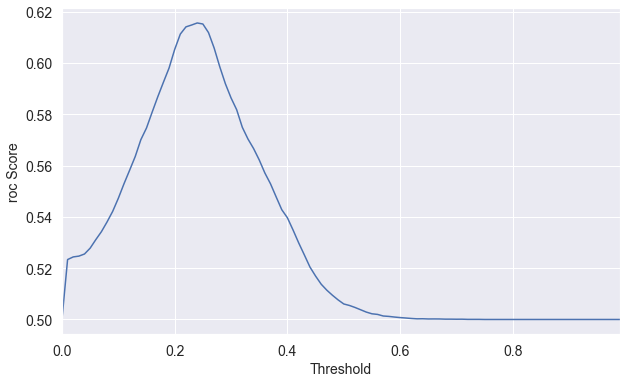

In [257]:
optimal_thresh = get_optimal_roc_thresh(target, lgb_oofs)
print(f'Optimal threhold is {optimal_thresh}')
roc_auc_score(target, (lgb_oofs > optimal_thresh) * 1)

In [258]:
lgb_preds_rounded = (lgb_preds > optimal_thresh) * 1

#final prediction end here 




#testing start...........................................................










In [259]:
#del train['days_since_prev_campaign_contact']

In [260]:
'''def run_gradient_boosting(clf, fit_params, train, test, features):
  N_SPLITS = 7
  oofs = np.zeros(len(train_proc))
  preds = np.zeros((len(test_proc)))

  folds = StratifiedKFold(n_splits = N_SPLITS)

  for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train[TARGET_COL])):
    print(f'\n------------- Fold {fold_ + 1} -------------')

    ### Training Set
    X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]

    ### Validation Set
    X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]

    ### Test Set
    X_test = test[features]

    scaler = StandardScaler()
    _ = scaler.fit(X_trn)

    X_trn = scaler.transform(X_trn)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    _ = clf.fit(X_trn, y_trn, eval_set = [(X_val, y_val)], **fit_params)

    ### Instead of directly predicting the classes we will obtain the probability of positive class.
    preds_val = clf.predict_proba(X_val)[:, 1]
    preds_test = clf.predict_proba(X_test)[:, 1]

    fold_score = roc_auc_score(y_val, preds_val.round())
    print(f'\nroc score for validation set is {fold_score}')

    oofs[val_idx] = preds_val
    preds += preds_test / N_SPLITS


  oofs_score = roc_auc_score(target, oofs.round())
  print(f'\n\nroc score for oofs is {oofs_score}')

  return oofs, preds'''

"def run_gradient_boosting(clf, fit_params, train, test, features):\n  N_SPLITS = 7\n  oofs = np.zeros(len(train_proc))\n  preds = np.zeros((len(test_proc)))\n\n  folds = StratifiedKFold(n_splits = N_SPLITS)\n\n  for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train[TARGET_COL])):\n    print(f'\n------------- Fold {fold_ + 1} -------------')\n\n    ### Training Set\n    X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]\n\n    ### Validation Set\n    X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]\n\n    ### Test Set\n    X_test = test[features]\n\n    scaler = StandardScaler()\n    _ = scaler.fit(X_trn)\n\n    X_trn = scaler.transform(X_trn)\n    X_val = scaler.transform(X_val)\n    X_test = scaler.transform(X_test)\n    \n    _ = clf.fit(X_trn, y_trn, eval_set = [(X_val, y_val)], **fit_params)\n\n    ### Instead of directly predicting the classes we will obtain the probability of positive class.\n    preds_val = clf.predict_proba(X_val

In [261]:
'''clf = LGBMClassifier(boosting_type='goss',
    learning_rate=0.01,
    n_estimators=1000,
    class_weight='balanced',
    colsample_bytree=.7,
    random_state=None,
    importance_type='split'
                        
                        )
fit_params = {'verbose': 100, 'early_stopping_rounds': 10000}

lgb_oofs, lgb_preds = run_gradient_boosting(clf, fit_params, train_proc, test_proc, features)

optimal_thresh = get_optimal_roc_thresh(target, lgb_oofs)
print(f'Optimal threhold is {optimal_thresh}')
optimized_f1 = roc_auc_score(target, (lgb_oofs > optimal_thresh) * 1)
print(f'Optimized roc is {optimized_f1}')'''

"clf = LGBMClassifier(boosting_type='goss',\n    learning_rate=0.01,\n    n_estimators=1000,\n    class_weight='balanced',\n    colsample_bytree=.7,\n    random_state=None,\n    importance_type='split'\n                        \n                        )\nfit_params = {'verbose': 100, 'early_stopping_rounds': 10000}\n\nlgb_oofs, lgb_preds = run_gradient_boosting(clf, fit_params, train_proc, test_proc, features)\n\noptimal_thresh = get_optimal_roc_thresh(target, lgb_oofs)\nprint(f'Optimal threhold is {optimal_thresh}')\noptimized_f1 = roc_auc_score(target, (lgb_oofs > optimal_thresh) * 1)\nprint(f'Optimized roc is {optimized_f1}')"

In [262]:
lgb_preds_rounded = (lgb_preds > optimal_thresh) * 1


In [263]:
lgb_preds_rounded


array([1, 0, 1, ..., 0, 0, 0])

In [264]:
ss.head()

,ID,Response
0,50883,1
1,50884,1
2,50885,1
3,50886,0
4,50887,0


In [265]:
ss['Response'] = lgb_preds_rounded


In [266]:
ss.head()

,ID,Response
0,50883,1
1,50884,0
2,50885,1
3,50886,0
4,50887,0


In [267]:
ss.to_csv(" frist36 outcome.csv", index= False)

In [268]:
ss.head()

,ID,Response
0,50883,1
1,50884,0
2,50885,1
3,50886,0
4,50887,0


In [269]:
len(ss)

21805

In [270]:
ss.tail()

,ID,Response
21800,72683,0
21801,72684,0
21802,72685,0
21803,72686,0
21804,72687,0


In [271]:
lgb_preds

array([0.28335625, 0.19999518, 0.27919121, ..., 0.00297054, 0.2227625 ,
       0.11369996])

In [244]:
optimal_thresh

0.48

In [245]:
(lgb_preds > optimal_thresh)

array([ True,  True,  True, ..., False, False, False])

In [137]:
(lgb_preds > optimal_thresh)*1

array([1, 1, 1, ..., 0, 1, 0])